# Import libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Pull all data into df

In [ ]:
soda = "https://data.cityofnewyork.us/resource/43nn-pn8j.json"

limit = 50000 # max limit of soda api
offset = 0

all_data = []

while True:
    parameters = {
        "$limit": limit,
        "$offset": offset,
    }

    response = requests.get(soda, params=parameters)

    if response.status_code == 200:
        data = response.json()
        if not data:
            break
        # append data from this iteration and increase offset
        all_data.extend(data)
        offset += limit
    else:
        print("Error:", response.status_code, response.text)
        break

df = pd.DataFrame(all_data)
display(df)

,camis,dba,boro,building,street,zipcode,phone,inspection_date,critical_flag,record_date,...,bbl,nta,cuisine_description,action,score,inspection_type,violation_code,violation_description,grade,grade_date
0,50129815,GREYWIND,Manhattan,451,10 AVENUE,10018,6468531933,1900-01-01T00:00:00.000,Not Applicable,2023-11-29T06:00:09.000,...,1007070031,MN13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50100800,CLAUDY'S KITCHEN,Bronx,5981,BROADWAY,10471,7188847378,1900-01-01T00:00:00.000,Not Applicable,2023-11-29T06:00:09.000,...,2058011036,BX29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,40600383,FERRARA'S,Manhattan,195,GRAND STREET,10013,2122266150,2021-09-17T00:00:00.000,Not Applicable,2023-11-29T06:00:07.000,...,1002370013,MN24,Bakery Products/Desserts,No violations were recorded at the time of thi...,0,Inter-Agency Task Force / Initial Inspection,NaN,NaN,NaN,NaN
3,50130968,CASELLULA,Manhattan,401,WEST 52 STREET,10019,16072210610,1900-01-01T00:00:00.000,Not Applicable,2023-11-29T06:00:09.000,...,1010620029,MN15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50142894,MANHATTAN SCHOOL OF MUSIC,Manhattan,120,CLAREMONT AVENUE,10027,7043285184,1900-01-01T00:00:00.000,Not Applicable,2023-11-29T06:00:09.000,...,1019930001,MN09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209665,41176692,EL SOL DE MEXICO DELI GROCERY,Queens,9509,SUTPHIN BOULEVARD,11435,7186580231,2022-03-29T00:00:00.000,Not Critical,2023-11-29T06:00:07.000,...,4100270036,QN61,Mexican,Violations were cited in the following area(s).,12,Cycle Inspection / Initial Inspection,10F,Non-food contact surface improperly constructe...,A,2022-03-29T00:00:00.000
209666,50033659,NEW GREAT TAYSTEE GARDENS,Queens,8118,LEFFERTS BLVD,11415,7188492288,2022-06-09T00:00:00.000,Critical,2023-11-29T06:00:07.000,...,4033370038,QN60,Chinese,Violations were cited in the following area(s).,25,Cycle Inspection / Initial Inspection,02G,Cold food item held above 41º F (smoked fish a...,NaN,NaN
209667,50134632,SIMPLY CARIBBEAN,Queens,11916,ROCKAWAY BLVD,11420,7182105520,2023-08-17T00:00:00.000,Not Critical,2023-11-29T06:00:07.000,...,4117120043,QN55,Caribbean,Violations were cited in the following area(s).,23,Pre-permit (Operational) / Initial Inspection,10B,Anti-siphonage or back-flow prevention device ...,N,NaN
209668,50116782,CASINO,Manhattan,171,EAST BROADWAY,10002,6468640101,2023-04-27T00:00:00.000,Not Critical,2023-11-29T06:00:07.000,...,1002840025,MN28,Other,Violations were cited in the following area(s).,7,Pre-permit (Operational) / Initial Inspection,10F,Non-food contact surface or equipment made of ...,A,2023-04-27T00:00:00.000


# Handle empty data

### 1. Filling score

In [ ]:
df['score'] = pd.to_numeric(df['score'], errors='coerce')

median = df['score'].median()

# grade to score dict
grade_to_score = {
    np.nan: median, # median of all records
    'N': median, # median of all records
    'Z': median, # median of all records
    'P': median, # median of all records
    'A': df[(df['score'] >= 0) & (df['score'] < 14)]['score'].median(), # median of not-null 'A' records
    'B': df[(df['score'] >= 14) & (df['score'] < 27)]['score'].median(), # median of not-null 'B' records
    'C': df[df['score'] >= 27]['score'].median() # median of not-null 'C' records
}

# apply the dict
df['score'] = df.apply(
    lambda row: grade_to_score.get(row['grade'], row['score']) if pd.isna(row['score']) else row['score'],
    axis=1
)

# force dtype
df['score'] = df['score'].astype(float)


### 2. Filling action and cuisine_description

In [ ]:
df['action'].fillna(value='Missing', inplace=True)
df['cuisine_description'].fillna(value='Other', inplace=True)

### 3. Filling everything else

In [ ]:
for column in df.columns:
    if df[column].dtype in [np.float64, np.int64]:  # for numeric-type columns
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)
    else: # for string-type columns
        df[column] = df[column].fillna(df[column].mode()[0])

df.fillna('N/A', inplace=True)
df.replace(['nan', 'NaN', np.nan], 'N/A', inplace=True)

# Strip spaces to mitigate negative effects of typos in data entry, etc.

In [ ]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# sort by earliest to latest

In [ ]:
df = df.sort_values(by=['inspection_date'])

# Agg data

### 1. break inspection date

In [ ]:
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['inspection_year'] = df['inspection_date'].dt.year
df['inspection_month'] = df['inspection_date'].dt.month
df['inspection_day'] = df['inspection_date'].dt.day

### 2. Violation_percentage (the percentage of PAST records of this restaurant having a violation, out of all its PAST records)

In [ ]:
# create a temp column indicating the current record has a violation
df['has_violation'] = df['action'].str.contains('Violations were cited|Establishment').fillna(0).astype(int)

# calculate cumulative count of number of inspections/violations up to current record, of this camis(restaurant)
df['num_inspections'] = df.groupby('camis').cumcount()
df['cumulative_violations'] = df.groupby('camis')['has_violation'].cumsum() - df['has_violation'] # take out current row

# calculate violation percentage
df.loc[df['num_inspections'] == 0, 'violation_percentage'] = 0 # set the 'violation_percentage' to 0, if there weren't any past violations
df.loc[df['num_inspections'] != 0, 'violation_percentage'] = df['cumulative_violations'] / df['num_inspections'] # basic cal if there were past violations

# drop temp column
df.drop(['has_violation'], axis=1, inplace=True)

### 3. Percentage_critical, Percentage_not_critical, Critical_to_non_critical_ratio (out of all PAST records of this restaurant)

In [ ]:
# convert 'Not Applicable' to 'Not Critical'
  #(treating them the same, as Not Applicable usually indicates no violation, which can be translated to "no critical violation" for our study)
df['critical_flag'] = df['critical_flag'].replace({'Not Applicable': 'Not Critical'})

# create binary columns is_critical/is_not_critical for easier calculation, indicating whether the current record has a critical violation or not
df['is_critical'] = (df['critical_flag'] == 'Critical').astype(int)
df['is_not_critical'] = (df['critical_flag'] == 'Not Critical').astype(int)

# calculate cumulative counts for both cases up to this record, of this camis(restaurant)
df['num_critical'] = df.groupby('camis')['is_critical'].cumsum() - df['is_critical'] # take out current row
df['num_not_critical'] = df.groupby('camis')['is_not_critical'].cumsum() - df['is_not_critical'] # take out current row

# calculate total inspection count up to this record
df['total_inspections'] = df['num_critical'] + df['num_not_critical']

# calculate the percentages of critical/non-critical up to this record
df['percentage_critical'] = (df['num_critical'] / df['total_inspections']).fillna(0)
df['percentage_not_critical'] = (df['num_not_critical'] / df['total_inspections']).fillna(0)

# get the ratio
df['critical_to_non_critical_ratio'] = df['num_critical'] / (df['num_not_critical'] + 1)  # Adding 1 to avoid division by zero

# drop temp columns
df.drop(['is_critical', 'is_not_critical', 'total_inspections'], axis=1, inplace=True)

### 4. Violation_code_freq & Violation_code_freq_by_camis: get past frequency of the violation code this record has, both in all records and in the past records of only this camis

In [ ]:
# get cumulative count of the violation_code of current record, in all past records
df['violation_code_freq'] = df.groupby(['violation_code']).cumcount()
df['violation_code_freq'].fillna(0, inplace=True)

# Inverse transformation
df['violation_code_freq'] = 1 / (df['violation_code_freq'] + 1e-5)


# Exponential Decay
df['violation_code_freq'] = df['violation_code_freq'] * np.exp(-df['violation_code_freq'])

# df['violation_code_freq'] = np.log1p(df['violation_code_freq'])
'''
max_freq = df['violation_code_freq'].max()
df['violation_code_freq'] = df['violation_code_freq'] / max_freq
'''


low_f = df["violation_code_freq"].quantile(0.01)
high_f = df["violation_code_freq"].quantile(0.99)
print("1% quantitile for violation_code_freq: ",(low_f, high_f))
df = df.loc[(df["violation_code_freq"] >= low_f) & (df["violation_code_freq"] <= high_f)]


# get cumulative count of the violation_code of current record, in past records of this current camis(restaurant)
df['violation_code_freq_by_camis'] = df.groupby(['camis','violation_code']).cumcount()
df['total_by_camis'] = df.groupby('camis').cumcount()
df['violation_code_freq_by_camis']= df['violation_code_freq_by_camis']/(df['total_by_camis'])
df['violation_code_freq_by_camis'].fillna(0, inplace=True)

# df['violation_code_freq_by_camis'] = np.log1p(df['violation_code_freq_by_camis'])

# low_cc = df["violation_code_freq_by_camis"].quantile(0.01)
# high_cc = df["violation_code_freq_by_camis"].quantile(0.99)
# print("1% quantitile for violation_code_freq_by_camis: ",(low_cc, high_cc))
# df = df.loc[(df["violation_code_freq_by_camis"] >= low_cc) & (df["violation_code_freq_by_camis"] <= high_cc)]


1% quantitile for violation_code_freq:  (3.284793931286696e-05, 0.0499331056297875)


5. the critical_flag and violation_code for the previous inspection of this restaurant

In [ ]:
df = df.sort_values(by=['camis','inspection_date'])
df['prev_violation_code'] = df.groupby('camis')['violation_code'].shift(1).fillna('Unknown')
df['prev_critical'] = df.groupby('camis')['critical_flag'].shift(1).fillna('Unknown')

In [ ]:
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# counter = 0
# col = [df["score"],df["violation_percentage"],df["num_critical"],df["num_inspections"]]
# title = ["score","violation_percentage","num_critical","num_inspections"]
# for i in range(2):
#   for j in range(2):
#     ax = axes[i][j]
#     if counter < 4:
#       ax.hist(col[counter], bins=20, color='blue', alpha=0.5)
#       ax.set_xlabel("%s" %title[counter])
#       ax.set_ylabel('Frequency')
#       # ax.set_title("%s" %title[counter], fontsize=12)
#       ax.set_ylim([0, 10000])
#       leg = ax.legend(loc='upper left')
#       leg.draw_frame(False)
#     counter += 1
# plt.show()

# Remove Outliers for: num_inspections, score, critical_to_non_critical_ratio, num_critical

In [ ]:
#drop the lowest 1% and the highest 99%
# 1. violation_code_freq
# 2. score
# 3. critical_to_non_critical_ratio
# 4. violation_code_freq_by_camis
# 5. inspection_year

# 1. violation_code_freq
# 2. score
# 3. cuisine_description
# 4. critical_to_non_critical_ratio
# 5. inspection_year
low_i = df["num_inspections"].quantile(0.01)
high_i = df["num_inspections"].quantile(0.99)
print("1% quantitile for num_inspections: ",(low_i, high_i))
low_s = df["score"].quantile(0.01)
high_s = df["score"].quantile(0.99)
print("1% quantitile for score: ",(low_s, high_s))

1% quantitile for num_inspections:  (0.0, 25.0)
1% quantitile for score:  (0.0, 81.0)


In [ ]:
low_r = df["critical_to_non_critical_ratio"].quantile(0.01)
high_r = df["critical_to_non_critical_ratio"].quantile(0.99)
print("1% quantitile for critical_to_non_critical_ratio: ",(low_r, high_r))

low_c = df["num_critical"].quantile(0.01)
high_c = df["num_critical"].quantile(0.99)
print("1% quantitile for num_critical: ",(low_c, high_c))


1% quantitile for critical_to_non_critical_ratio:  (0.0, 4.0)
1% quantitile for num_critical:  (0.0, 15.0)


In [ ]:
df = df.loc[(df["num_inspections"] >= low_i) & (df["num_inspections"] <= high_i )]
df = df.loc[(df["score"] >= low_s) & (df["score"] <= high_s)]
df = df.loc[(df["critical_to_non_critical_ratio"] >= low_r) & (df["critical_to_non_critical_ratio"] <= high_r)]
df = df.loc[(df["num_critical"] >= low_c) & (df["num_critical"] <= high_c)]


# keep only selected features + target

In [ ]:
# df = df.drop_duplicates(subset='camis', keep='last').copy()

In [ ]:
df = df[[#'grade',
         'score',
         'num_inspections', 'violation_percentage',
         'inspection_year', 'inspection_month',
         'percentage_critical', 'percentage_not_critical',
         'critical_to_non_critical_ratio',
         'boro',
         'cuisine_description',
         'dba',
         'zipcode',
         'prev_violation_code', 'prev_critical',
         'violation_code_freq',
         'violation_code_freq_by_camis',
         'critical_flag']]

In [ ]:
df

,score,num_inspections,violation_percentage,inspection_year,inspection_month,percentage_critical,percentage_not_critical,critical_to_non_critical_ratio,boro,cuisine_description,dba,zipcode,prev_violation_code,prev_critical,violation_code_freq,violation_code_freq_by_camis,critical_flag
62556,5.0,0,0.0,2021,8,0.000000,0.000000,0.000000,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,Unknown,Unknown,0.001976,0.0,Critical
31111,21.0,1,1.0,2023,1,1.000000,0.000000,1.000000,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,06E,Critical,0.001435,0.0,Not Critical
105812,21.0,2,1.0,2023,1,0.500000,0.500000,0.500000,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,10D,Not Critical,0.000045,0.0,Not Critical
67590,21.0,3,1.0,2023,1,0.333333,0.666667,0.333333,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,10F,Not Critical,0.000104,0.0,Critical
32265,21.0,4,1.0,2023,1,0.500000,0.500000,0.666667,Bronx,Bakery Products/Desserts,MORRIS PARK BAKE SHOP,10462,06D,Critical,0.000134,0.0,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Manhattan,Other,DUNKIN,10036,Unknown,Unknown,0.000544,0.0,Not Critical
119132,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Queens,Other,DUNKIN,10013,Unknown,Unknown,0.005587,0.0,Not Critical
201180,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Manhattan,Other,CM CHICKEN OF MANHATTAN,10128,Unknown,Unknown,0.001912,0.0,Not Critical
109003,19.0,0,0.0,1900,1,0.000000,0.000000,0.000000,Brooklyn,Other,DUNKIN,11215,Unknown,Unknown,0.003559,0.0,Not Critical


# Label the categoricals

In [ ]:
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object' and col != 'critical_flag':
        df[col] = le.fit_transform(df[col])

print(df)

        score  num_inspections  violation_percentage  inspection_year  \
62556     5.0                0                   0.0             2021   
31111    21.0                1                   1.0             2023   
105812   21.0                2                   1.0             2023   
67590    21.0                3                   1.0             2023   
32265    21.0                4                   1.0             2023   
...       ...              ...                   ...              ...   
290      19.0                0                   0.0             1900   
119132   19.0                0                   0.0             1900   
201180   19.0                0                   0.0             1900   
109003   19.0                0                   0.0             1900   
19952    19.0                0                   0.0             1900   

        inspection_month  percentage_critical  percentage_not_critical  \
62556                  8             0.000000    

# 4. Data splitting and scaling

## Use newest record for each restaurant as the testing data; every older record as training data

Advantages:
1. Further prevent data leakage
2. Simulate real-world situation (predicting off of newest records, but training with older data); prevents using future data to predict past events which is not realistic
3. Potentially captures trends over time

In [ ]:
# convert 'critical_flag' to binary format
df['critical_flag_binary'] = df['critical_flag'].apply(lambda x: 1 if x == 'Critical' else 0)

# separate features and target variable
X = df.drop(['critical_flag', 'critical_flag_binary'], axis=1)
y = df['critical_flag_binary']

# identify the latest record for each 'dba'
latest_records = df.groupby('dba').tail(1)

# split the data into training and test sets
test_indices = latest_records.index
train_df = df.drop(test_indices)
test_df = df.loc[test_indices]

# extract features and labels for both training and test sets
X_train = train_df[X.columns]
y_train = train_df['critical_flag_binary']
X_test = test_df[X.columns]
y_test = test_df['critical_flag_binary']

# print the proportion
train_proportion = len(train_df) / len(df)
test_proportion = len(test_df) / len(df)
print(f"Training set proportion: {train_proportion:.2f}")
print(f"Test set proportion: {test_proportion:.2f}")


Training set proportion: 0.89
Test set proportion: 0.11


### Simple breaking into 80/20 proportion (commented out)

In [ ]:
'''y_binary = df['critical_flag'].apply(lambda x: 1 if x == 'Critical' else 0)

X = df.drop(['critical_flag'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

'''
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


"y_binary = df['critical_flag'].apply(lambda x: 1 if x == 'Critical' else 0)\n\nX = df.drop(['critical_flag'], axis=1)\nX_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)\n\n"

# 5. Handle Class Imbalance using Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE

# sampling_strategy = {0: 100000, 1: 200000}
# smote = SMOTE(sampling_strategy=sampling_strategy, random_state=512)

smote = SMOTE(random_state=512)

# fit SMOET on training data
X_train, y_train = smote.fit_resample(X_train, y_train)


# Plotting function

In [ ]:
import matplotlib.pyplot as plt
# Plotting the confusion matrix:
def confusion_matrix_plot(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Modeling

In [ ]:
import itertools
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
class_names = ['Not Critical', 'Critical']

## 1. Logistic Regression

Logistic Regression Train Accuracy:  57.56151967216424 %
Logistic Regession Test Accuracy:  56.36232276709112 %
              precision    recall  f1-score   support

           0       0.54      0.89      0.67     11170
           1       0.67      0.23      0.35     10976

    accuracy                           0.56     22146
   macro avg       0.61      0.56      0.51     22146
weighted avg       0.61      0.56      0.51     22146



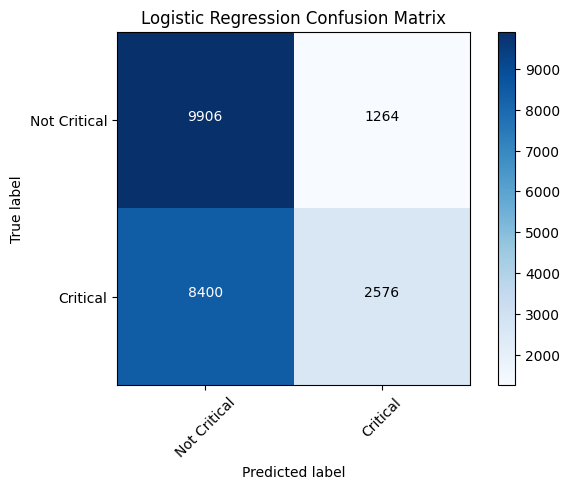

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import itertools

logr = LogisticRegression(
    penalty='l2',
    C=1.0,
    fit_intercept=True,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced'
)

logr.fit(X_train, y_train)
y_pred_test_logr = logr.predict(X_test)
y_pred_train_logr = logr.predict(X_train)

print('Logistic Regression Train Accuracy: ', accuracy_score(y_train, y_pred_train_logr)*100,'%')
print('Logistic Regession Test Accuracy: ', accuracy_score(y_test, y_pred_test_logr)*100,'%')

print(classification_report(y_test, y_pred_test_logr))

cm_logr = confusion_matrix(y_test, y_pred_test_logr)

confusion_matrix_plot(cm_logr, classes=class_names, title='Logistic Regression Confusion Matrix')


## 2. Decision Tree

Decision Tree Train Accuracy:  87.68597210166138 %
Decision Tree Test Accuracy:  86.16889931250668 %
Decision Tree Train Accuracy:  87.68597210166138 %
Decision Tree Test Accuracy:  86.19163731599386 %
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     11170
           1       0.88      0.84      0.86     10976

    accuracy                           0.86     22146
   macro avg       0.86      0.86      0.86     22146
weighted avg       0.86      0.86      0.86     22146



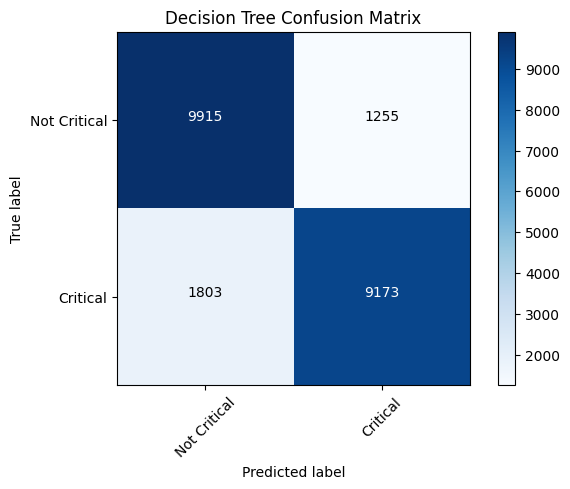

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    criterion='entropy',
    splitter='best',
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features=None
)

dt.fit(X_train, y_train)
y_pred_test_dt = dt.predict(X_test)
y_pred_train_dt = dt.predict(X_train)

print('Decision Tree Train Accuracy: ', accuracy_score(y_train, y_pred_train_dt)*100,'%')
print('Decision Tree Test Accuracy: ', accuracy_score(y_test, y_pred_test_dt)*100,'%')

print(classification_report(y_test, y_pred_test_dt))

cm_dt = confusion_matrix(y_test, y_pred_test_dt)
confusion_matrix_plot(cm_dt, classes=class_names, title='Decision Tree Confusion Matrix')
#71.53822080066239 %   72.34972141086375 %

## 3. Random Forest

Random Forest Train Accuracy:  90.94565678179947 %
Random Forest Test Accuracy:  87.47855143140974 %
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     11170
           1       0.86      0.89      0.88     10976

    accuracy                           0.87     22146
   macro avg       0.88      0.87      0.87     22146
weighted avg       0.88      0.87      0.87     22146



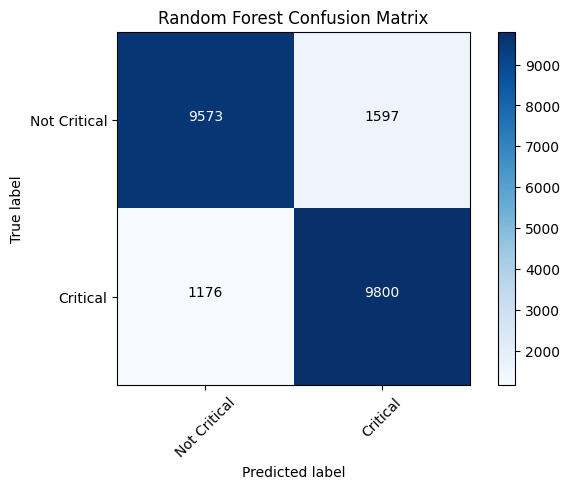

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300,
                            max_features='log2',
                            max_depth=20,
                            min_samples_split=10,
                            min_samples_leaf=4,
                            bootstrap=True,
                            oob_score=True,
                            class_weight='balanced'
                            )


rf.fit(X_train, y_train)
y_pred_test_rf = rf.predict(X_test)
y_pred_train_rf = rf.predict(X_train)

print('Random Forest Train Accuracy: ', accuracy_score(y_train, y_pred_train_rf)*100,'%')
print('Random Forest Test Accuracy: ', accuracy_score(y_test, y_pred_test_rf)*100,'%')

print(classification_report(y_test, y_pred_test_rf))

cm_rf = confusion_matrix(y_test, y_pred_test_rf)
confusion_matrix_plot(cm_rf, classes=class_names, title='Random Forest Confusion Matrix')
# 81.960   73.9892343
# 82.3769             73.68246
# 82.4342  72.88559  74.49602

## 4. Gradient Boosting Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


Gradient Boosting Train Accuracy:  88.04075741365041 %
Gradient Boosting Test Accuracy:  87.93461573196063 %
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     11170
           1       0.86      0.90      0.88     10976

    accuracy                           0.88     22146
   macro avg       0.88      0.88      0.88     22146
weighted avg       0.88      0.88      0.88     22146



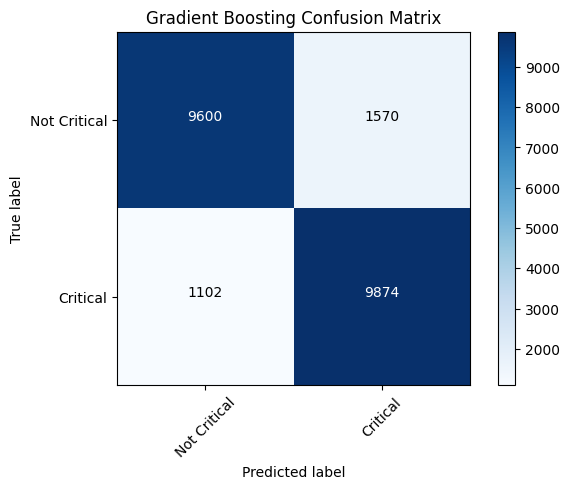

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_samples_split=50,
    min_samples_leaf=25,
    max_features='sqrt',
    subsample=0.8,
    loss='deviance',
    random_state=42,
    n_iter_no_change=10
)

gbc.fit(X_train, y_train)
y_pred_test_gbc = gbc.predict(X_test)
y_pred_train_gbc = gbc.predict(X_train)

print('Gradient Boosting Train Accuracy: ', accuracy_score(y_train, y_pred_train_gbc)*100,'%')
print('Gradient Boosting Test Accuracy: ', accuracy_score(y_test, y_pred_test_gbc)*100,'%')

print(classification_report(y_test, y_pred_test_gbc))

cm_gbc = confusion_matrix(y_test, y_pred_test_gbc)
confusion_matrix_plot(cm_gbc, classes=class_names, title='Gradient Boosting Confusion Matrix')


XGBoost Train Accuracy: 98.64697095100632%
XGBoost Test Accuracy: 92.21981396188929%
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     11170
           1       0.92      0.92      0.92     10976

    accuracy                           0.92     22146
   macro avg       0.92      0.92      0.92     22146
weighted avg       0.92      0.92      0.92     22146



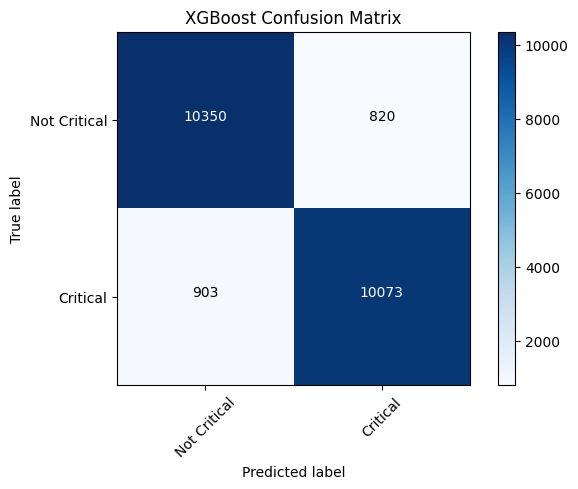

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    objective='binary:logistic',
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_train_xgb = xgb.predict(X_train)
y_pred_test_xgb = xgb.predict(X_test)

train_accuracy_xgb = accuracy_score(y_train, y_pred_train_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_pred_test_xgb)
print(f"XGBoost Train Accuracy: {train_accuracy_xgb*100} %")
print(f"XGBoost Test Accuracy: {test_accuracy_xgb*100} %")

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_test_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)
confusion_matrix_plot(cm_xgb, classes=class_names, title='XGBoost Confusion Matrix')

Top features for XGBoost Classifier and their importance:
                       feature  importance
           violation_code_freq    0.231110
               inspection_year    0.141451
                         score    0.086963
                 prev_critical    0.083531
              inspection_month    0.080508
  violation_code_freq_by_camis    0.057311
critical_to_non_critical_ratio    0.045657
          violation_percentage    0.045456
       percentage_not_critical    0.044676
               num_inspections    0.036835
           percentage_critical    0.032911
           prev_violation_code    0.030011
                           dba    0.021277
                       zipcode    0.021042
           cuisine_description    0.020979
                          boro    0.020282


<Figure size 1000x800 with 0 Axes>

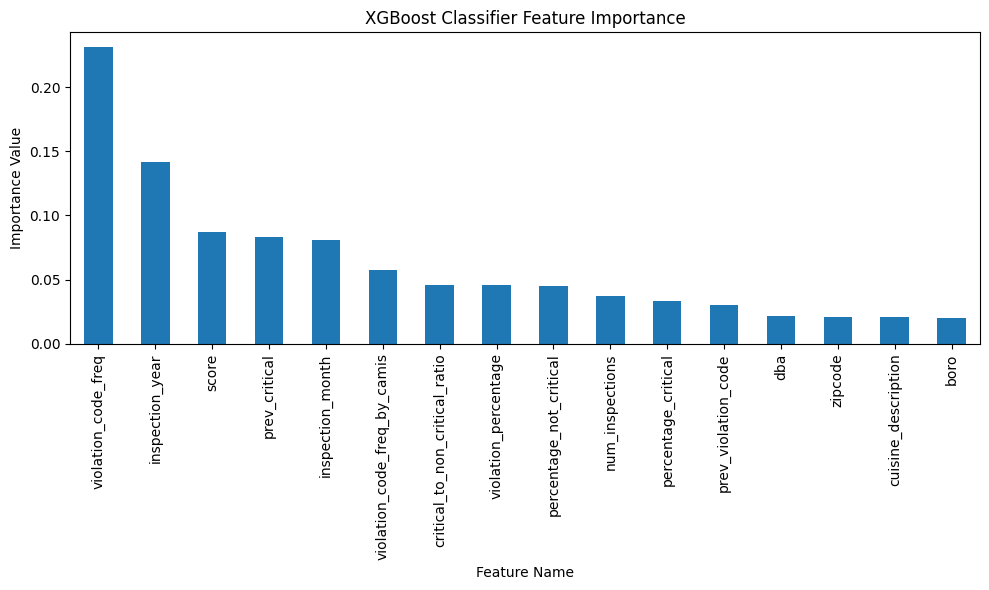

In [ ]:
# extract feature importances
importances_xgb = xgb.feature_importances_
importance_df_xgb = pd.DataFrame({'feature': feature_names, 'importance': importances_xgb})

# sort dataframe by importance magnitude
importance_df_xgb = importance_df_xgb.sort_values(by='importance', ascending=False)

# print the top features in a DataFrame style
print("Top features for XGBoost Classifier and their importance:")
print(importance_df_xgb.to_string(index=False))

# visualzition
plt.figure(figsize=(10, 8))
importance_df_xgb.plot(kind='bar', x='feature', y='importance', legend=False, figsize=(10, 6))
plt.title('XGBoost Classifier Feature Importance')
plt.ylabel('Importance Value')
plt.xlabel('Feature Name')
plt.tight_layout()
plt.show()


In [ ]:
'''from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# base models
base_models = [
    ('logr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier(max_depth=10, min_samples_split=50, min_samples_leaf=20)),
    ('rf', RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=15, min_samples_split=10, min_samples_leaf=4, bootstrap=True, oob_score=True, class_weight='balanced')),
    ('gbc', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=8, min_samples_split=50, min_samples_leaf=25, max_features='sqrt', subsample=0.8))
]

# Stacking Classifier with the Meta model
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

stacked_model.fit(X_train, y_train)

y_pred_train_stacked = stacked_model.predict(X_train)
y_pred_test_stacked = stacked_model.predict(X_test)

print('Stacked Model Train Accuracy: ', balanced_accuracy_score(y_train, y_pred_train_stacked) * 100, '%')
print('Stacked Model Test Accuracy: ', balanced_accuracy_score(y_test, y_pred_test_stacked) * 100, '%')

print("Stacked Model Classification Report:")
print(classification_report(y_test, y_pred_test_stacked))

cm_stacked = confusion_matrix(y_test, y_pred_test_stacked)
class_names = ['Not Critical', 'Critical']  # Adjust based on your label encoder
confusion_matrix_plot(cm_stacked, classes=class_names, title='Stacked Model Confusion Matrix')
'''

'from sklearn.ensemble import StackingClassifier\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier\n\n# base models\nbase_models = [\n    (\'logr\', LogisticRegression(max_iter=1000)),\n    (\'dt\', DecisionTreeClassifier(max_depth=10, min_samples_split=50, min_samples_leaf=20)),\n    (\'rf\', RandomForestClassifier(n_estimators=500, max_features=\'sqrt\', max_depth=15, min_samples_split=10, min_samples_leaf=4, bootstrap=True, oob_score=True, class_weight=\'balanced\')),\n    (\'gbc\', GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=8, min_samples_split=50, min_samples_leaf=25, max_features=\'sqrt\', subsample=0.8))\n]\n\n# Stacking Classifier with the Meta model\nstacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())\n\nstacked_model.fit(X_train, y_train)\n\ny_pred_train_stacked = stack